In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import os
import datetime
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('questions_processed.csv')
df


,What do you want to know about GCSE Computer Science?,Section
0,a lot of coding knowing components and etc,2c
1,Advanced Coding,2c
2,Do we do use python or repl.it for coding,2d
3,Do we get to programme bots and stuff like that.,2d
4,do we go through the things we did in year 7 a...,2e
...,...,...
126,"Will the course involve programmings. if yes, ...",2c
127,Will we be able to create our own apps?,2d
128,Will we learn about how people steal passwords...,2a
129,Would there be things in Computer science and ...,5b


In [4]:
training_data = df[df.columns[0]].to_numpy()
training_data = np.reshape(training_data,(-1,1))
training_data[:6]

array([['a lot of coding knowing components and etc'],
       ['Advanced Coding'],
       ['Do we do use python or repl.it for coding'],
       ['Do we get to programme bots and stuff like that.'],
       ['do we go through the things we did in year 7 and 8'],
       ["Do we revise everything we've done in year 7 to 9 during GCSE?"]],
      dtype=object)

In [5]:
vectorizer = layers.TextVectorization(output_mode="int")
vectorizer.adapt(training_data)
integer_data = vectorizer(training_data)
print(integer_data)


tf.Tensor(
[[ 28  56  10 ...   0   0   0]
 [293  21   0 ...   0   0   0]
 [ 11   4  11 ...   0   0   0]
 ...
 [  6   4  25 ...   0   0   0]
 [ 31  27  16 ...   0   0   0]
 [ 11   4  25 ...   0   0   0]], shape=(131, 28), dtype=int64)


In [6]:
labels = df[df.columns[1]]
y = np.argmax(pd.get_dummies(labels).to_numpy(), axis=1)
X_train, X_test, y_train, y_test = train_test_split(training_data, y, test_size=0.20, random_state=42, stratify=y)


In [7]:
max_features = 20000
embedding_dim = 30

inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorizer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)

#x = layers.LSTM(10, dropout=0.2, recurrent_dropout=0.2)(x)
x = tf.keras.layers.GRU(10)(x)

x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.3)(x)
num_classes = 10
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 30)          600030    
                                                                 
 gru (GRU)                   (None, 10)                1260      
                                                                 
 dense (Dense)               (None, 20)                220       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                             

In [8]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    keras.callbacks.TensorBoard(logdir)
]
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/10
3/3 [==============================] - 7s 584ms/step - loss: 2.3066 - acc: 0.0602 - val_loss: 2.3002 - val_acc: 0.1429
Epoch 2/10
3/3 [==============================] - 0s 43ms/step - loss: 2.2988 - acc: 0.2289 - val_loss: 2.2934 - val_acc: 0.1905
Epoch 3/10
3/3 [==============================] - 0s 42ms/step - loss: 2.2933 - acc: 0.1928 - val_loss: 2.2864 - val_acc: 0.6190
Epoch 4/10
3/3 [==============================] - 0s 44ms/step - loss: 2.2897 - acc: 0.2169 - val_loss: 2.2782 - val_acc: 0.6190
Epoch 5/10
3/3 [==============================] - 0s 43ms/step - loss: 2.2780 - acc: 0.4337 - val_loss: 2.2694 - val_acc: 0.6190
Epoch 6/10
3/3 [==============================] - 0s 43ms/step - loss: 2.2703 - acc: 0.4578 - val_loss: 2.2606 - val_acc: 0.6190
Epoch 7/10
3/3 [==============================] - 0s 42ms/step - loss: 2.2691 - acc: 0.3855 - val_loss: 2.2507 - val_acc: 0.6190
Epoch 8/10
3/3 [==============================] - 0s 42ms/step - loss: 2.2504 - acc: 0.3373 - va

In [9]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10448), started 0:01:08 ago. (Use '!kill 10448' to kill it.)

In [10]:
model.evaluate(X_test,y_test)


1/1 [==============================] - 0s 33ms/step - loss: 2.2296 - acc: 0.5185


[2.2296175956726074, 0.5185185074806213]

In [12]:
predictions = model.predict(X_test)
print(predictions.shape)

1/1 [==============================] - 0s 28ms/step
(27, 10)


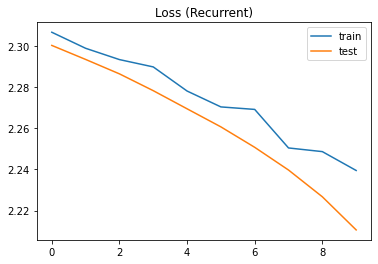

In [13]:
plt.title('Loss (Recurrent)')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()